Here we will examine a simple orbital dynamics problem with Poynting-Robertson drag in order to characterize the slimplectic Galerkin-Gauss-Lobatto integrator. The Lagrangian for a central gravitional potential (with mass $M_\odot$ is given by
$$ L = \frac{1}{2} m \dot{\mathbf q}^2 + (1-\beta)\frac{GM_{\odot}m}{r}$$
with nonconservative potential given by (up to terms linear in $v/c$)
$$ K = -\frac{\beta G M m }{c r_+^2} \left[\left(\delta_{ij} + \frac{q_{i+} q_{j+}}{r_+^2}\right)\dot{q}_+^i q_-^j\right] = -\frac{\beta G M_\odot m }{c r_+^2} \left[\dot{{\mathbf q}}_+ \cdot {\mathbf q}_- + \frac{1}{r_+^2}(\dot{{\mathbf q}}_+ \cdot {\mathbf q}_+)({\mathbf q}_+ \cdot {\mathbf q}_-)\right]$$
where 
$$\beta \simeq \frac{3L_\odot}{8\pi c \rho G M_\odot d} \simeq 0.0576906 \left(\frac{\rho}{2\, {\rm g}\,{\rm cm}^{-3}} \right)^{-1} \left(\frac{d}{10^{-3} {\rm cm}} \right)^{-1}.$$
Here, $L_\odot$ is the sun's luminosity, $c$ is the speed of light, $\rho$ is the density of the dust grain, and $d$ is the diameter of the dust grain.


We adopt Cartesian coordinates for the orbital dynamics with
${\mathbf q} = x \hat{\mathbf x} + y \hat{\mathbf y} + z \hat{\mathbf z}$, with $r = ({\mathbf q} \cdot {\mathbf q})^{1/2}$.

In [1]:
%matplotlib inline
import numpy as np, matplotlib.pyplot as plt
import slimplectic, orbit_util as orbit

In [2]:
# Parameters
G = 39.478758435  #(in AU^3/M_sun/yr^2))
M_Sun = 1.0  #(in solar masses)
rho = 2.0  #(in g/cm^3)
d = 5.0e-3  #(in cm)
beta = 0.0576906*(2.0/rho)*(1.0e-3/d)  #(dimensionless)
c = 63241.3  #(in AU/yr)

### Slimplectic integration

In [3]:
# Create an instance of the GalerkinGaussLobatto class and call it `pr` for Poynting-Robinson
pr = slimplectic.GalerkinGaussLobatto('t', ['x', 'y', 'z'], ['vx', 'vy', 'vz'])

In [4]:
# Define the conservative $L$ and nonconservative $K$ parts of the total Lagrangian $\Lambda$
# We take the dust particle to have unit mass.
L = 0.5*np.dot(pr.v, pr.v) + (1.0 - beta)*G*M_Sun/np.dot(pr.q, pr.q)**0.5
K = np.dot(pr.vp, pr.qm) + np.dot(pr.vp, pr.qp)*np.dot(pr.qp, pr.qm)/np.dot(pr.qp, pr.qp)**0.5
K *= -beta*G*M_Sun/c/np.dot(pr.qp, pr.qp)**0.5

In [5]:
# Discretize total Lagrangian using a 2nd order (r=0) implicit scheme
pr.discretize(L, K, 0, method='implicit')

In [6]:
# Specify time samples at which the numerical solution is to be given and provide initial data.

# We take the initial orbital parameters to be given by:
# a = 1, e = 0, i = 0, omega = 0, Omega = 0, M = 0
q0, v0 = orbit.Calc_Cartesian(1.0, 0.2, 0.0, 0.0, 0.0, 0.0, (1.0-beta)*G*M_Sun)
pi0 = v0  # Dust taken to have unit mass

# Time samples (in years)
t_end = 6000
dt = 0.01
t = np.arange(0, t_end+dt, dt)

In [7]:
# Now integrate the 2nd order slimplectic integrator
q_slim2, pi_slim2 = pr.integrate(q0, pi0, t)

/Users/crgalley/anaconda/lib/python2.7/site-packages/scipy/optimize/minpack.py:237: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [8]:
# For a 4th order (r=1) implicit scheme we run
pr.discretize(L, K, 1, method='implicit')

# ...and then integrate to get the corresponding numerical solution
q_slim4, pi_slim4 = pr.integrate(q0, pi0, t)

We don't have an exact solution to compare our numerical results against. In lieu of this, we use a 6th order implicit slimplectic integrator as our "fiducial" solution for comparisons made below.

In [9]:
pr.discretize(L, K, 2, method='implicit')  # 6th order is r=2
q_slim6, pi_slim6 = pr.integrate(q0, pi0, t)

In [64]:
pr.discretize(L, K, 1, method='implicit')

alpha = beta*G*M_Sun/c
R0 = 1.

q0 = [R0*(1+beta), 0., 0.]
v0 = [-2.*alpha*R0, np.sqrt(G*M_Sun/R0)*(1.-2.*beta), 0.]
pi0 = v0

t_end = 6000
dt2 = 0.1
t2 = np.arange(0, t_end+dt2, dt2)

q_test, pi_test = pr.integrate(q0, pi0, t2)

TypeError: 'NoneType' object has no attribute '__getitem__'

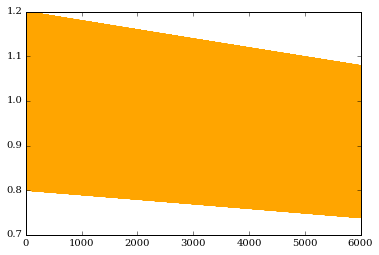

In [77]:
plt.plot(t, r_slim4, color='orange')
plt.plot(t2, np.sqrt(q_test[0]**2+q_test[1]**2+q_test[2]**2), 'r-')
plt.plot(t, R0*(1+beta)*np.exp(-2.*alpha/(1.+beta)*t), 'k-')
plt.xlim(0,10)

### Runge-Kutta integration

Generate the 2nd and 4th order Runge-Kutta solutions to compare below with output from the slimplectic integrators.

In [11]:
# Instantiate the 2nd and 4th order Runge-Kutta classes
rk2 = slimplectic.RungeKutta2()
rk4 = slimplectic.RungeKutta4()

# Define the derivative operator
def dydt(time, y):
    deriv = np.zeros(6)
    [q_x, q_y, q_z, v_x, v_y, v_z] = y
    r = (q_x*q_x + q_y*q_y + q_z*q_z)**0.5
    deriv[0] = v_x
    deriv[1] = v_y
    deriv[2] = v_z
    deriv[3] = -(1. - beta)*G*M_Sun*q_x/(r*r*r) 
    deriv[3] -=(beta*G*M_Sun/(c*r*r))*(v_x + q_x*(q_x*v_x + q_y*v_y + q_z*v_z)/(r*r))
    deriv[4] = -(1. - beta)*G*M_Sun*q_y/(r*r*r)
    deriv[4] -=(beta*G*M_Sun/(c*r*r))*(v_y + q_y*(q_x*v_x + q_y*v_y + q_z*v_z)/(r*r))
    deriv[5] = -(1. - beta)*G*M_Sun*q_z/(r*r*r)
    deriv[5] -=(beta*G*M_Sun/(c*r*r))*(v_z + q_z*(q_x*v_x + q_y*v_y + q_z*v_z)/(r*r))
    
    return deriv

# Integrate
q_rk2, v_rk2 = rk2.integrate(q0, v0, t, dydt)
q_rk4, v_rk4 = rk4.integrate(q0, v0, t, dydt)

# Please note that q and pi are outputs of the slimplectic integration, 
# while q and v are output from the Runge-Kutta integrators.

## Comparison plots

Plot the $x$-component of the orbital vector ${\mathbf q}(t)$ for the 2nd and 4th order slimplectic and RK integrators along with the "fiducial" 6th order slimplectic solution.

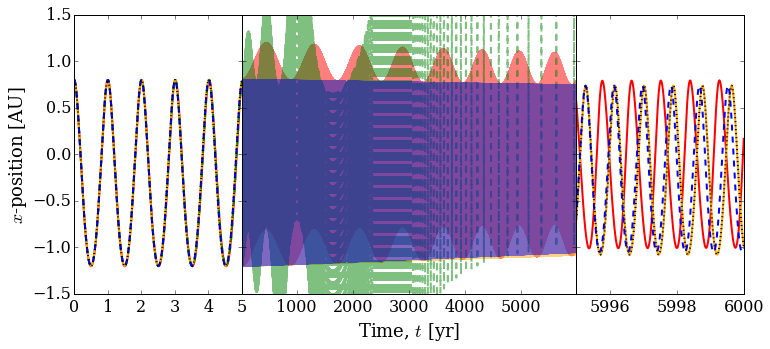

In [33]:
fig1 = plt.figure(figsize=(12,5), dpi=800)
fig1.subplots_adjust(wspace=0)

ax1a = fig1.add_subplot(1,4,1)
ax1a.set_ylim(-1.5, 1.5)
ax1a.set_xlim(0,5)
ax1a.plot(t, q_slim2[0], 'r-', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_slim4[0], color='orange', linestyle='-', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_rk2[0], 'g--', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_rk4[0], 'b--', linewidth=2.0, rasterized=True)
ax1a.plot(t, q_slim6[0], 'k:', linewidth=2.0, rasterized=True)

ax1b = fig1.add_subplot(1,4,(2,3))
plt.setp(ax1b.get_yticklabels(), visible=False)
ax1b.set_ylim(-1.5, 1.5)
ax1b.set_xlim(5,5995)
ax1b.set_xticks([1000, 2000, 3000, 4000, 5000])
ax1b.plot(t, q_slim2[0], 'r-',  linewidth=2.0, alpha=.5, rasterized=True)
ax1b.plot(t, q_slim4[0], color='orange', linestyle='-', linewidth=2.0, alpha=.5, rasterized=True)
ax1b.plot(t, q_rk2[0], 'g--', linewidth=2.0, alpha=.5,  rasterized=True)
ax1b.plot(t, q_rk4[0], 'b--',  linewidth=2.0, alpha=.5, rasterized=True)

ax1c = fig1.add_subplot(1,4,4)
plt.setp(ax1c.get_yticklabels(), visible=False)
ax1c.set_ylim(-1.5, 1.5)
ax1c.set_xlim(5995,6000)
ax1c.set_xticks([5996, 5998, 6000])
ax1c.get_xaxis().get_major_formatter().set_useOffset(False)
ax1c.plot(t, q_slim2[0], 'r-', linewidth=2.0, rasterized=True)
ax1c.plot(t, q_slim4[0], color='orange', linestyle='-', linewidth=2.0, rasterized=True)
ax1c.plot(t, q_rk2[0], 'g--', linewidth=2.0, rasterized=True)
ax1c.plot(t, q_rk4[0], 'b--', linewidth=2.0, rasterized=True)
ax1c.plot(t, q_slim6[0], 'k:', linewidth=2.0, rasterized=True)

ax1a.tick_params(axis='both', which='major', labelsize=16)
ax1b.tick_params(axis='both', which='major', labelsize=16)
ax1c.tick_params(axis='both', which='major', labelsize=16)

ax1b.set_xlabel('Time, $t$ [yr]', fontsize=18)
ax1a.set_ylabel('$x$-position [AU]', fontsize=18);

In [32]:
# Most of the integrators preserve the dust particle's motion in the x-y plane.
# The 2nd order slimplectic integrator is the only one that exhibits motion in the z-plane.
print np.all(q_slim2[2] == 0.)
print np.all(q_slim4[2] == 0.)
print np.all(q_slim6[2] == 0.)
print np.all(q_rk2[2] == 0.)
print np.all(q_rk4[2] == 0.)

False
True
True
True
True


## Old stuff below

In [24]:
def convert_to_3D(q, pi):
    r = column_stack((q[0,:], 
                      q[1,:], 
                      numpy.zeros(len(q[0,:]))))
    v = column_stack((pi[0,:], 
                      pi[1,:], 
                      numpy.zeros(len(pi[0,:]))))
    return r,v

def Energy(q, pi):
    E = 0.5*pi[0,:]*pi[0,:] + 0.5*pi[1,:]*pi[1,:]
    E -= (1.0-beta)*G*M_Sun/(q[0,:]*q[0,:] + q[1,:]*q[1,:])**0.5
    return E

In [25]:
r2, v2 = convert_to_3D(q2, pi2)
r4, v4 = convert_to_3D(q4, pi4)
r6, v6 = convert_to_3D(q6, pi6)
r_rk2 = column_stack((qx_rk2, qy_rk2, numpy.zeros(len(qx_rk2))))
v_rk2 = column_stack((vx_rk2, vy_rk2, numpy.zeros(len(vx_rk2))))
r_rk4 = column_stack((qx_rk4, qy_rk4, numpy.zeros(len(qx_rk4))))
v_rk4 = column_stack((vx_rk4, vy_rk4, numpy.zeros(len(vx_rk4))))

In [26]:
E2 = Energy(q2, pi2)
E4 = Energy(q4, pi4)
E6 = Energy(q6, pi6)
E_rk2 = Energy(np.array([qx_rk2, qy_rk2]), np.array([vx_rk2, vy_rk2]))
E_rk4 = Energy(np.array([qx_rk4, qy_rk4]), np.array([vx_rk4, vy_rk4]))


In [27]:
E_rk4

array([-19.51162389, -19.51163093, -19.51163803, ..., -21.81279165,
       -21.81279367, -21.8127957 ])

In [28]:
e2 = numpy.zeros(len(r2))
e4 = numpy.zeros(len(r4))
e6 = numpy.zeros(len(r6))
e_rk2 = numpy.zeros(len(r_rk2))
e_rk4 = numpy.zeros(len(r_rk4))

a2 = numpy.zeros(len(r2))
a4 = numpy.zeros(len(r4))
a6 = numpy.zeros(len(r6))
a_rk2 = numpy.zeros(len(r_rk2))
a_rk4 = numpy.zeros(len(r_rk4))

for i in range(len(e2)):
    e2[i] = Kep.Calc_e(r2[i], v2[i], (1.0-beta)*G*M_Sun)
    e4[i] = Kep.Calc_e(r4[i], v4[i], (1.0-beta)*G*M_Sun)
    e6[i] = Kep.Calc_e(r6[i], v6[i], (1.0-beta)*G*M_Sun)
    e_rk2[i] = Kep.Calc_e(r_rk2[i], v_rk2[i], (1.0-beta)*G*M_Sun)
    e_rk4[i] = Kep.Calc_e(r_rk4[i], v_rk4[i], (1.0-beta)*G*M_Sun)

    a2[i] = Kep.Calc_a(r2[i], v2[i], (1.0-beta)*G*M_Sun)
    a4[i] = Kep.Calc_a(r4[i], v4[i], (1.0-beta)*G*M_Sun)
    a6[i] = Kep.Calc_a(r6[i], v6[i], (1.0-beta)*G*M_Sun)
    a_rk2[i] = Kep.Calc_a(r_rk2[i], v_rk2[i], (1.0-beta)*G*M_Sun)
    a_rk4[i] = Kep.Calc_a(r_rk4[i], v_rk4[i], (1.0-beta)*G*M_Sun)
    

In [29]:
q2[0,:]

array([ 0.8       ,  0.79695131,  0.78784247, ...,  0.60932906,
        0.66175075,  0.70922502])

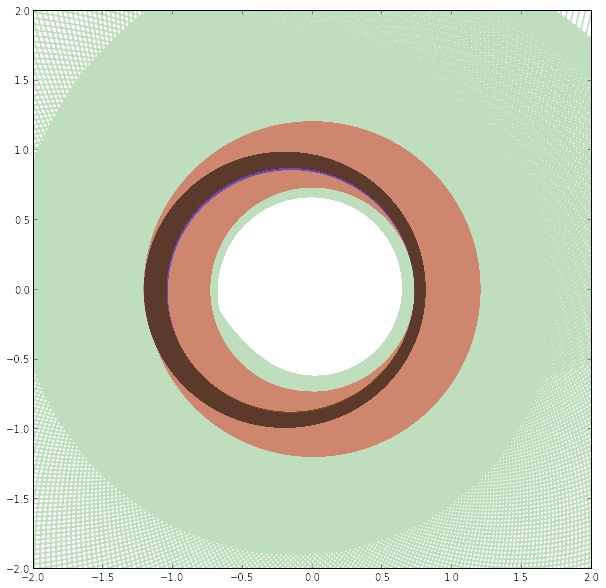

In [30]:
fig2 = pylab.figure(figsize=(10,10), dpi=500)
ax2 = fig2.add_subplot(1,1,1)
ax2.set_ylim(-2, 2)
ax2.set_xlim(-2, 2)
ax2.plot(qx_rk2[:], qy_rk2[:],
    linewidth=2.0, linestyle='-', alpha=.5,color='g')
ax2.plot(q2[0,:], q2[1,:],
    linewidth=2.0, linestyle='-', alpha=.5,color='r')
ax2.plot(qx_rk4[:], qy_rk4[:],
    linewidth=2.0, linestyle='-', alpha=.5,color='b')
ax2.plot(q4[0,:], q4[1,:],
    linewidth=2.0, linestyle='-', alpha=.5,color='orange')
ax2.plot(q6[0,:], q6[1,:],
    linewidth=2.0, linestyle='-', alpha=.5,color='black')


In [59]:
fig1.savefig(plot_path + "PRDrag_xLong.pdf", transparent=True,bbox_inches='tight', dpi=500)

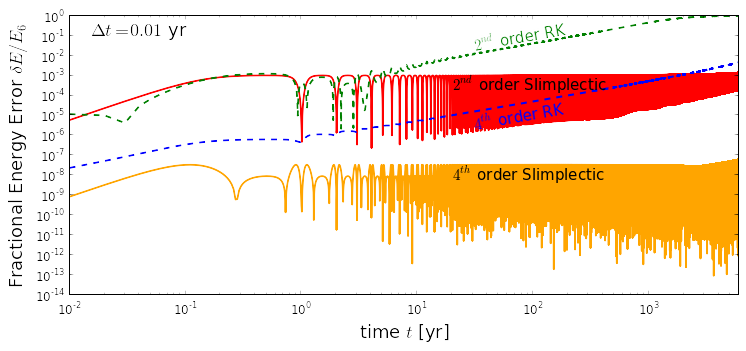

In [57]:
fig5 = plt.figure(figsize=(12,5), dpi=500)
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xscale('log')
ax5.set_yscale('log')
ax5.set_xlim(0.01, 6000)
ax5.plot(t, np.abs((E2-E6)/E6),
    linewidth=2.0, linestyle='-', color='r', rasterized=True)
ax5.plot(t, np.abs((E4-E6)/E6),
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax5.plot(t, np.abs((E_rk2-E6)/E6),
    linewidth=2.0, linestyle='--', color='g', rasterized=True)
ax5.plot(t, np.abs((E_rk4-E6)/E6),
    linewidth=2.0, linestyle='--', color='b', rasterized=True)
ax5.set_xlabel('time $t$ [yr]', fontsize=18)
ax5.set_ylabel('Fractional Energy Error $\delta E/E_6$', fontsize=18)
ax5.text(20, 1.8e-4, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
ax5.text(20, 0.5e-8, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
ax5.text(30, 1e-5, r'$4^{th}$ order RK', fontsize=15, color='blue', rotation = 10)
ax5.text(30, 1e-1, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=10)
ax5.text(0.015, 1e-1, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')

ax5.tick_params(axis='both', which='major', labelsize=12)



In [60]:
fig5.savefig(plot_path + "PRDrag_E_errorLong.pdf", transparent=True,bbox_inches='tight', dpi=500)

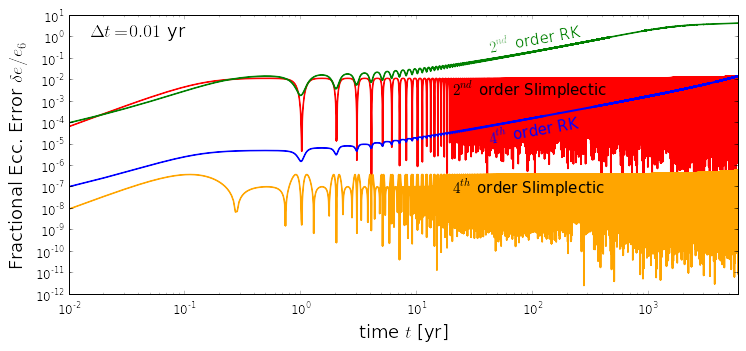

In [49]:
fig2 = plt.figure(figsize=(12,5), dpi=500)
ax2 = fig2.add_subplot(1,1,1)
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlim(0.01, 6000)
ax2.plot(t, np.abs((e2-e6)/e6),
    linewidth=2.0, linestyle='-', color='r', rasterized=True)
ax2.plot(t, np.abs((e4-e6)/e6),
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax2.plot(t, np.abs((e_rk2-e6)/e6),
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax2.plot(t, np.abs((e_rk4-e6)/e6),
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax2.set_xlabel('time $t$ [yr]', fontsize=18)
ax2.set_ylabel('Fractional Ecc. Error $\delta e/e_6$', fontsize=18)
ax2.text(20, 1.8e-3, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
ax2.text(20, 0.5e-7, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
ax2.text(40, 0.5e-4, r'$4^{th}$ order RK', fontsize=15, color='blue', rotation = 10)
ax2.text(40, 1e0, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=10)
ax2.tick_params(axis='both', which='major', labelsize=12)
ax2.text(0.015, 1e0, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')


In [50]:
fig2.savefig(plot_path + "PRDrag_Ecc_errorLong.pdf", transparent=True,bbox_inches='tight', dpi=300)

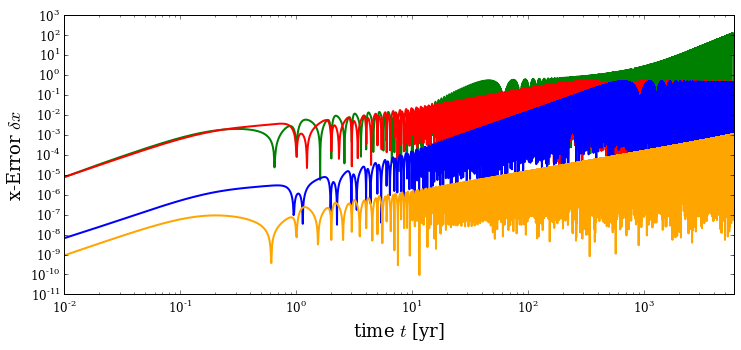

In [37]:
r_slim2 = np.sqrt(q_slim2[0]**2 + q_slim2[1]**2 + q_slim2[2]**2)
r_slim4 = np.sqrt(q_slim4[0]**2 + q_slim4[1]**2 + q_slim4[2]**2)
r_slim6 = np.sqrt(q_slim6[0]**2 + q_slim6[1]**2 + q_slim6[2]**2)
r_rk2 = np.sqrt(q_rk2[0]**2 + q_rk2[1]**2 + q_rk2[2]**2)
r_rk4 = np.sqrt(q_rk4[0]**2 + q_rk4[1]**2 + q_rk4[2]**2)

fig7 = plt.figure(figsize=(12,5), dpi=500)
ax7 = fig7.add_subplot(1,1,1)
ax7.set_xscale('log')
ax7.set_yscale('log')
ax7.set_xlim(0.01, 6000)
ax7.plot(t, np.abs(r_rk2/r_slim6-1.),
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax7.plot(t, np.abs(r_slim2/r_slim6-1.),
    linewidth=2.0, linestyle='-', color='r', rasterized=True)

ax7.plot(t, np.abs(r_rk4/r_slim6-1.),
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax7.plot(t, np.abs(r_slim4/r_slim6-1.),
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)

ax7.set_xlabel('time $t$ [yr]', fontsize=18)
ax7.set_ylabel('x-Error $\delta x$', fontsize=18)
#ax7.text(20, 1.8e-4, r'$2^{nd}$ order Slimplectic', fontsize=15, color='black')
#ax7.text(20, 0.5e-8, r'$4^{th}$ order Slimplectic', fontsize=15, color='black')
#ax7.text(30, 1e-5, r'$4^{th}$ order RK', fontsize=15, color='blue', rotation = 10)
#ax7.text(30, 1e-1, r'$2^{nd}$ order RK', fontsize=15, color='g', rotation=10)
#ax7.text(0.015, 1e-1, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')

ax7.tick_params(axis='both', which='major', labelsize=12)


In [52]:
#fig7.savefig(plot_path + "PRDrag_x_errorLong.pdf", transparent=True,bbox_inches='tight', dpi=300)

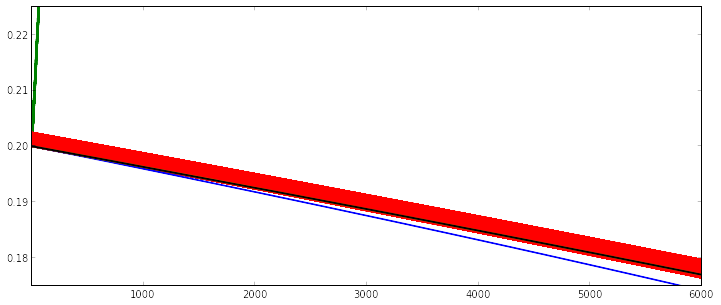

In [45]:
fig8 = plt.figure(figsize=(12,5), dpi=500)
ax8 = fig8.add_subplot(1,1,1)
ax8.set_ylim(0.175, 0.225)
ax8.set_xlim(0.01, 6000)

ax8.plot(t, e_rk2,
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax8.plot(t, e2,
    linewidth=2.0, linestyle='-', color='r', rasterized=True)

ax8.plot(t, e_rk4,
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax8.plot(t, e4,
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax8.plot(t, e6,
    linewidth=2.0, linestyle='-', color='black', rasterized=True)


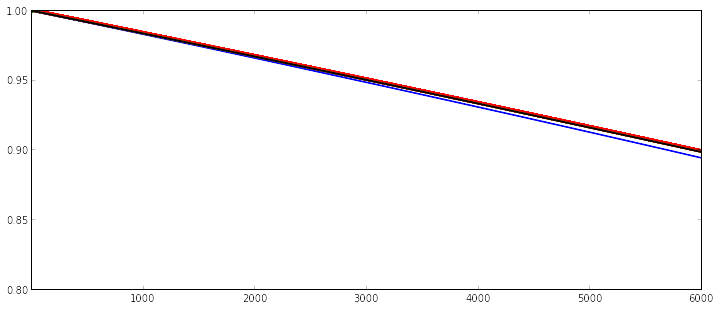

In [48]:
fig9 = plt.figure(figsize=(12,5), dpi=500)
ax9 = fig9.add_subplot(1,1,1)
ax9.set_ylim(0.8, 1.0)
ax9.set_xlim(0.01, 6000)

ax9.plot(t, a_rk2,
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax9.plot(t, a2,
    linewidth=2.0, linestyle='-', color='r', rasterized=True)

ax9.plot(t, a_rk4,
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax9.plot(t, a4,
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax9.plot(t, a6,
    linewidth=2.0, linestyle='-', color='black', rasterized=True)

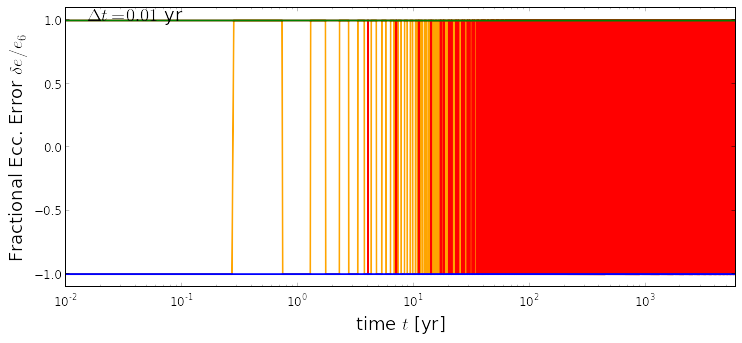

In [56]:
fig5 = plt.figure(figsize=(12,5), dpi=500)
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xscale('log')
ax5.set_ylim(-1.1, 1.1)
ax5.set_xlim(0.01, 6000)
ax5.plot(t, np.sign((e4-e6)),
    linewidth=2.0, linestyle='-', color='orange', rasterized=True)
ax5.plot(t, np.sign((e2-e6)),
    linewidth=2.0, linestyle='-', color='r', rasterized=True)
ax5.plot(t, np.sign((e_rk2-e6)),
    linewidth=2.0, linestyle='-', color='g', rasterized=True)
ax5.plot(t, np.sign((e_rk4-e6)),
    linewidth=2.0, linestyle='-', color='b', rasterized=True)
ax5.set_xlabel('time $t$ [yr]', fontsize=18)
ax5.set_ylabel('Fractional Ecc. Error $\delta e/e_6$', fontsize=18)
ax5.tick_params(axis='both', which='major', labelsize=12)
ax5.text(0.015, 1e0, r'$\Delta t = 0.01$ yr', fontsize=18, color='black')
